# Exam Data Science I  
### Exam I in the Summer Term 2024

## General Information

* You have one week to complete the exam. 

* You can use all sources freely, but you must name them correctly. If you use ChatGPT or similar software, you must include the prompt.

* You should use the following packages: `numpy, pandas, scipy, geopy, scikit-learn/sklearn, matplotlib, seaborn, openpyxl` and Python's native libraries. These are sufficient to solve the exam. If you use other libraries, justify their use.

* Code must be sufficiently commented to be understandable. Write functions whenever you reuse code. In general, follow the guidelines from the lecture. Points may be deducted due to poorly structured or incomprehensible code.

* **Always justify (!)** decisions regarding the choice of plots, hypothesis tests, etc. in writing and **interpret** your results.

* You are **not** allowed to seek help or advice from other people in any way. 

* Please submit the complete repository as a `.zip` file with the name `surname_matrikelnummer.zip` by August 8th, 2024 at 12:00 noon on StudIP to the folder `Submission - Exam 1`.

* Also add the signed code of conduct to the `.zip` file. 

* If you have any questions, please contact us via Rocketchat in a timely manner.

## Exercises and Points:

<table>
  <thead>
    <tr>
      <th colspan="3">Exercise 1 - Data Preprocessing</th>
      <th colspan="2">Exercise 2 - Plotting</th>
      <th colspan="2">Exercise 3 - Statistics</th>
      <th colspan="2">Exercise 4 - Machine Learning </th>
    </tr>
    <tr>
      <th>Exercise 1.1</th>
      <th>Exercise 1.2</th>
      <th>Exercise 1.3</th>
      <th>Exercise 2.1</th>
      <th>Exercise 2.2</th>
      <th>Exercise 3.1</th>
      <th>Exercise 3.2</th>
      <th>Exercise 4.1</th>
      <th>Exercise 4.2</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10 points </td>
      <td>12 points </td>
      <td>2 points </td>
      <td>11 points</td>
      <td>27 points </td>
      <td>13 points </td>
      <td>5 points </td>
      <td>10 points </td>
      <td>10 points </td>
    </tr>
    <!-- Add more rows as needed -->
  </tbody>
</table>


_____
## Exercise 0: Setup

The exam folder contains a `Dockerfile` in which all relevant libraries are defined. The `Dockerfile` builds up on the Jupyter Server image. Use this Dockerfile to first create a Docker image and then start a Docker container from that image. Afterwards log into the Jupyter Server instance to work on the exam. We strongly recommend using the Docker environment to avoid version conflicts between the various libraries. Code that does not run in this environment will be graded as **non functional**.

____
## Exercise 1: Data Preprocessing (24 points)

### Data Description

In the data folder, you will find the parking data in Göttingen city for the year 2023 as one file per month. The parking tickets bought using the stationary ticket machines are in the files whose names start with `Cale` and the parking tickets bought with the parkster app are in the files whose names start with `Parkster`. <br> 
The file `parkzone_latlong.csv` provides further geographical information regarding the parkzones and the file `psa_latlong.csv` provides geographical information about the parking machines within the parkzones.

The parking data provided is genuine raw data and comes directly from the city of Göttingen. We have only added the geographical information. 

*Please note:*
- *in the following the term "parking ticket" refers to a piece of paper that entitles you to park and not a fine for illegal parking.*
- *although we only have data from February to December, we will refer to all data available as yearly.*
- *due to the size of the data it might be necessary to use your memory efficiently, therefore avoid storing several copies of the same DataFrame.*

#### Exercise 1.1 - Data Loading (10 points)
Load the files for the machines (`Cale-*`) and for the app (`Parkster-*`) and concatenate all months to get two DataFrames, one for the machine and one for the app purchase for the whole year.
Also load the machine (`psa_latlong.csv`) and the parkzone information (`parkzones_latlong.csv`).

You will find the values `0` and `999` in the `Automaten ID` column for the machine data. Change the `0`s to `1`s and drop all entries with `999`.
Also check whether there are any duplicate rows and delete them. 

In [ ]:
import os
from os.path import join
import pandas as pd

DATA_DIR = "data"
PICKLE_DIR = "pickles"
CALE_COLS = {
    "Automat - Automaten ID": "machine_ID",
    "Kaufdatum Lokal": "time",
    "Betrag": "fee",
}
PARKSTER_COLS = {
    "Start": "time",
    "Parkgebühren inkl. MwSt. in EUR": "fee",
    "Zonencode": "zone",
}


def deduplicate_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    original_length = len(df)
    # df_deduped = df.drop_duplicates(keep="first")
    df_deduped = df.drop_duplicates()
    rows_removed = original_length - len(df_deduped)
    print(f"Rows removed due to deduplication: {rows_removed}")
    return df_deduped


def process_cale_file(path: str):
    df = pd.read_excel(
        path,
        sheet_name="Verkaufsliste",
        skiprows=[0, 1],
        usecols=list(CALE_COLS.keys()),
        parse_dates=["Kaufdatum Lokal"],
        date_format="%d.%m.%Y %H:%M:%S",
        decimal=".",
    ).rename(columns=CALE_COLS)
    df["machine_ID"] = pd.to_numeric(
        df["machine_ID"].str.replace("PA", ""),
        errors="coerce",
    ).replace(0, 1)
    df = df.drop(df.loc[df["machine_ID"] == 999].index)
    df["category"] = "machine"
    # df = df.drop_duplicates(["machine_ID"])
    return df


def process_parkster_file(path: str):
    df = pd.read_excel(
        path,
        sheet_name="Göttingen",
        usecols=list(PARKSTER_COLS.keys()),
        parse_dates=["Start"],
        date_format="%Y-%m-%d %H:%M:%S",
        decimal=",",
        dtype={
            "Parkgebühren inkl. MwSt. in EUR": "float64",
            "Zonencode": "int64",
        },
    ).rename(columns=PARKSTER_COLS)
    df["category"] = "app"
    return df


def load_psa_latlong(path: str):
    df = pd.read_csv(path).rename(columns={"PSA": "machine_ID"})
    df["machine_ID"] = pd.to_numeric(
        df["machine_ID"], downcast="integer", errors="coerce"
    )
    df.dropna(subset=["machine_ID"], inplace=True)
    df["machine_ID"] = df["machine_ID"].astype(int)
    df.set_index("machine_ID", inplace=True)
    return df


def load_parkzones_latlong(path: str):
    return pd.read_csv(path, usecols=["latitude", "longitude", "Zonencode"]).rename(
        columns={"Zonencode": "zone"}
    )


def process_excel_files(prefix: str) -> pd.DataFrame:
    """
    Loads and concatenates either Cale- or Parkster- excel sheets.
    """
    pickle_file = os.path.join(PICKLE_DIR, f"{prefix}_df")
    if os.path.exists(pickle_file):
        print(f"Loading DataFrame from {pickle_file}")
        return pd.read_pickle(pickle_file)

    files = [
        f for f in os.listdir(DATA_DIR) if f.startswith(prefix) and f.endswith(".xlsx")
    ]
    dfs = []

    for file in files:
        path = join(DATA_DIR, file)
        print(f"Loading {path}")
        df = (
            process_cale_file(path)
            if prefix.startswith("Cale")
            else process_parkster_file(path)
        )
        dfs.append(df)

    # df = deduplicate_dataframe(pd.concat(dfs, ignore_index=True))
    df = pd.concat(dfs, ignore_index=True)
    df.to_pickle(pickle_file)
    return df


def merge_and_format_data(
    cale_df: pd.DataFrame,
    parkster_df: pd.DataFrame,
    parkzones_latlong_df: pd.DataFrame,
    psa_latlong_df: pd.DataFrame,
) -> pd.DataFrame:
    """
    This function produces the final dataframe for exercise 1.2 by
    merging all the loaded data as specified.
    """
    cale_merged = pd.merge(
        cale_df,
        psa_latlong_df,
        on="machine_ID",
        how="left",
    ).rename(
        columns={
            "latitude": "latitude_machine",
            "longitude": "longitude_machine",
            "location": "street",
        }
    )

    print("Shapes after merging Cale and PSA LatLong:")
    print(f"Cale merged DataFrame shape: {cale_merged.shape}")

    combined_df = pd.concat([cale_merged, parkster_df], ignore_index=True)

    print("Shapes after concatenating Cale and Parkster:")
    print(f"Combined DataFrame shape: {combined_df.shape}")

    final_df = pd.merge(combined_df, parkzones_latlong_df, on="zone", how="left")

    print("Shapes after merging with Parkzones LatLong:")
    print(f"Final DataFrame shape: {final_df.shape}")

    final_df = final_df.rename(
        columns={"latitude": "latitude_zone", "longitude": "longitude_zone"}
    )

    return (
        final_df.astype(
            {
                "machine_ID": "Int64",
                "fee": "float64",
                "category": "object",
                "street": "object",
                "latitude_machine": "float64",
                "longitude_machine": "float64",
                "zone": "int64",
                "latitude_zone": "float64",
                "longitude_zone": "float64",
            }
        )
        .set_index("time")
        .sort_index()
    )


cale_df = process_excel_files("Cale")
parkster_df = process_excel_files("Parkster")

parkzones_latlong_df = load_parkzones_latlong(join(DATA_DIR, "parkzones_latlong.csv"))
parkzones_latlong_df.info()
parkzones_latlong_df.to_pickle("pickles/parkzones_latlong")

psa_latlong_df = load_psa_latlong(join(DATA_DIR, "psa_latlong.csv"))
psa_latlong_df.to_pickle("pickles/psa_latlong")

print("\nData Processing Summary:")
print(f"Cale DataFrame shape: {cale_df.shape}")
cale_df.info()
print(f"Parkster DataFrame shape: {parkster_df.shape}")
parkster_df.info()
print(f"Parkzones LatLong DataFrame shape: {parkzones_latlong_df.shape}")
parkzones_latlong_df.info()
print(f"PSA LatLong DataFrame shape: {psa_latlong_df.shape}")
psa_latlong_df.info()

# # Stage 3: Merge and format data
final_df = merge_and_format_data(
    cale_df, parkster_df, parkzones_latlong_df, psa_latlong_df
)

print("\nFinal DataFrame:")
final_df.info()
final_df.to_csv("out/final_df.csv")

#### Exercise 1.2 - Merging and Formating (12 points)
Concatenate the app and machine data, using the parkzones *(in `parkzones_latlong.csv`)* and the parking machine number *(in `psa_latlong.csv`)*. Make sure that you have the geographical information for both, the parking machines and the parkzones, in the final data frame. 
Use the columns `Kaufdatum Lokal` and `Start` for the date of purchase, encode the column as a `datetime` object and use it as index column. Also make sure that the other columns have a reasonable data format. 


*Note: Having `NaN` values for some columns in the rows belonging to app purchases can be expected.*

In [ ]:
def merge_and_format_data(
    cale_df: pd.DataFrame,
    parkster_df: pd.DataFrame,
    parkzones_latlong_df: pd.DataFrame,
    psa_latlong_df: pd.DataFrame,
) -> pd.DataFrame:
    """
    This function produces the final dataframe for exercise 1.2 by
    merging all the loaded data as specified.
    """
    cale_merged = pd.merge(
        cale_df,
        psa_latlong_df,
        on="machine_ID",
        how="left",
    ).rename(
        columns={
            "latitude": "latitude_machine",
            "longitude": "longitude_machine",
            "location": "street",
        }
    )

    print("Shapes after merging Cale and PSA LatLong:")
    print(f"Cale merged DataFrame shape: {cale_merged.shape}")

    combined_df = pd.concat([cale_merged, parkster_df], ignore_index=True)

    print("Shapes after concatenating Cale and Parkster:")
    print(f"Combined DataFrame shape: {combined_df.shape}")

    final_df = pd.merge(combined_df, parkzones_latlong_df, on="zone", how="left")

    print("Shapes after merging with Parkzones LatLong:")
    print(f"Final DataFrame shape: {final_df.shape}")

    final_df = final_df.rename(
        columns={"latitude": "latitude_zone", "longitude": "longitude_zone"}
    )

    return (
        final_df.astype(
            {
                "machine_ID": "Int64",
                "fee": "float64",
                "category": "object",
                "street": "object",
                "latitude_machine": "float64",
                "longitude_machine": "float64",
                "zone": "int64",
                "latitude_zone": "float64",
                "longitude_zone": "float64",
            }
        )
        .set_index("time")
        .sort_index()
    )


final_df = merge_and_format_data(
    cale_df, parkster_df, parkzones_latlong_df, psa_latlong_df
)

print("\nFinal DataFrame:")
final_df.info()
final_df.to_csv("out/final_df.csv")

#### Exercise 1.3 - DataFrame Check (2 points)
The cleaned and complete DataFrame for the following exercises should look like `data/clean_dataframe.csv`, which can be read in correctly as follows:

In [ ]:
pd.read_csv('data/clean_dataframe.csv', parse_dates=['time'], index_col='time', dtype={'machine_ID': 'Int64', 
                                                                           'fee': 'float64', 
                                                                           'category': 'object', 
                                                                           'street': 'object', 
                                                                           'latitude_machine': 'float64', 
                                                                           'longitude_machine': 'float64', 
                                                                           'zone': 'int64', 
                                                                           'latitude_zone': 'float64', 
                                                                           'longitude_zone': 'float64'}).sort_index()

Make sure that your DataFrame aligns with `clean_dataframe.csv`. To prove this, use the function [`pandas.DataFrame.equals`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.equals.html).

If `pandas.DataFrame.equals` does not return `True`, please continue working with `clean_dataframe.csv` and indicate this using a Markdown cell. In that case you won't get any points for this subtask.

In [5]:
print("Reference DataFrame:")
clean_df = pd.read_csv(
    "data/clean_dataframe.csv",
    parse_dates=["time"],
    index_col="time",
    dtype={
        "machine_ID": "Int64",
        "fee": "float64",
        "category": "object",
        "street": "object",
        "latitude_machine": "float64",
        "longitude_machine": "float64",
        "zone": "int64",
        "latitude_zone": "float64",
        "longitude_zone": "float64",
    },
).sort_index()
clean_df.info()

print("\nComparison with Reference DataFrame:")
if final_df.shape == clean_df.shape and final_df.columns.equals(clean_df.columns):
    print("Shapes and columns match!")

    if final_df.equals(clean_df):
        print("Values match exactly!")
    else:
        print("Values differ.")
else:
    print("Shapes or columns do not match.")


Comparison with Reference DataFrame:


NameError: name 'final_df' is not defined

_____
## Exercise 2: Plotting (38 points)



### Exercise 2.1 - Analysis of Parking Machines (11 points)
The city of Göttingen would like to have an overview of the returns of the **individual parking machines** and hires you to carry out an initial explorative analysis of the sales volume and the geographical location of the machines.


#### 2.1.1 (6 points)
Find the top 5 parking machines regarding their sales volume in 2023 and plot their weekly turnover over the year.

#### 2.1.2 (5 points)
The location of the machines might also have an influence on the turnover. 

Familiarize yourself with the function `plot_map` from the library `dsplotter`. Use the function to plot the yearly turnover for each location. Make the color **and** the radius of the location marker dependent on the yearly turnover. Can you see any relationship between the machines with a high yearly turnover? 

### Exercise 2.2 - Analysis of Machine and App Usage per Zone (27 points)
As part of the city's digitization initiative, the Parkster app was introduced a few years ago as an alternative to parking machines. 
So far we have focused only on the parking machines and therefore discarded a bulk of ticket sales.
The city would like to carry out an initial visual analysis of the acceptance of the app in the individual parkzones in 2023 and analysis the total parking turnover. 

*Note that we can only analyse the total parking ticket sales by summarizing all parking machines per parkzone.*

#### 2.2.1 (6 points)
Do users prefer the app or the machine usage? 

Use an appropriate plot to show the average machine or app usage rate per **parkzone** for the whole year of 2023. What do you observe?

#### 2.2.2 (9 points)
How frequently are the individual parkzones used? 

Visualize the total number of parking tickets and the machine usage for each parkzone in 2023 in one plot. Use the a `log`-scale for the y-axis. What do you observe?

#### 2.2.3 (7 points)
The previous plot gives us an idea about the total number of *users* per parkzone. This number is likely highly correlated with the number of parking lots per zone. If we want to compare different parkzones with regard to their parking tickets sold, we should normalize them by the number of parking lots available. This way we can find out which zones are used most frequently. Because we don't have the number of parking lots available for each zone, we can only use the number of parking machines as a rough approximation for their sizes. 

Use the information from the `psa_latlong.csv` and reproduce the previous plot using the number of parking tickets normalized by the number of machines for each zone. Use the a `log`-scale for the y-axis.
Which parkzone is the busiest one?

#### 2.2.4 (5 points)
So far we haven't used the geographical information of the parkzones. 

Use the `plot_map`-function to plot the location (center) of all parkzones, their average tickets sold per machine and the rate of machine users. Color the location by the rate of machine users and set the radius using the tickets sold per machine. What do you observe?

        time  machine_ID    fee
0 2023-02-05           8  586.9
1 2023-02-05          17  547.6
2 2023-02-05          18  674.3
3 2023-02-05          53  745.9
4 2023-02-05          76  467.7
Top 5 machines by sales volume:
machine_ID
53    55854.3
17    42122.0
18    40313.5
8     39005.7
76    37815.5
Name: fee, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   machine_ID        196 non-null    Int64  
 1   yearly_sales_eur  196 non-null    float64
 2   latitude          196 non-null    float64
 3   longitude         196 non-null    float64
dtypes: Int64(1), float64(3)
memory usage: 6.4 KB

Yearly sales volume per machine:
     machine_ID  yearly_sales_eur   latitude  longitude
0             1           24061.9  51.529542   9.939956
1             2            8647.2  51.533104   9.926817
2             3           13846

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zone                  23 non-null     int64  
 1   total_transactions    23 non-null     int64  
 2   total_sales_volume    23 non-null     float64
 3   transactions_app      23 non-null     int64  
 4   transactions_machine  23 non-null     int64  
 5   sales_volume_app      23 non-null     float64
 6   sales_volume_machine  23 non-null     float64
dtypes: float64(3), int64(4)
memory usage: 1.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zone                  23 non-null     int64  
 1   total_transactions    23 non-null     int64  
 2   total_sales_volume    23 non-null     float64
 3   transactions_app      23 no

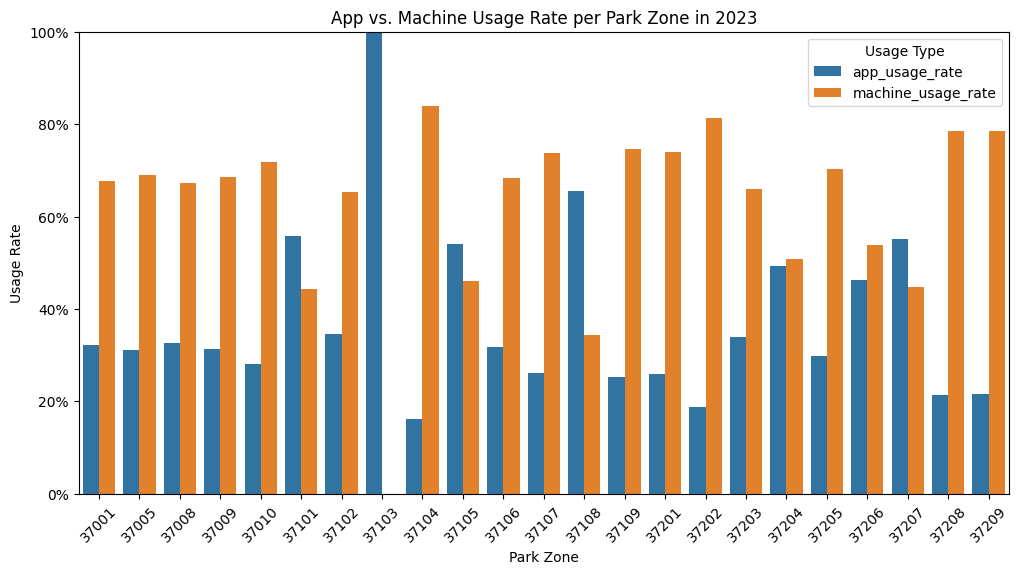

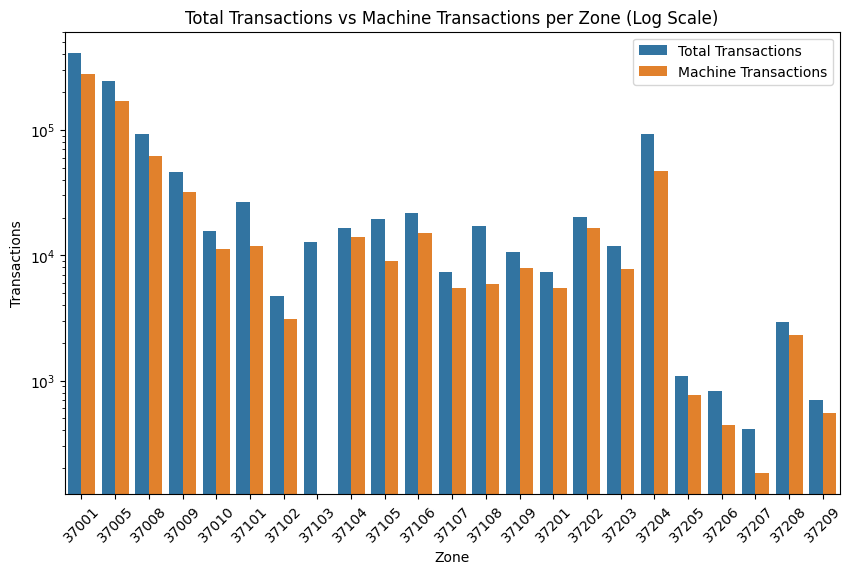

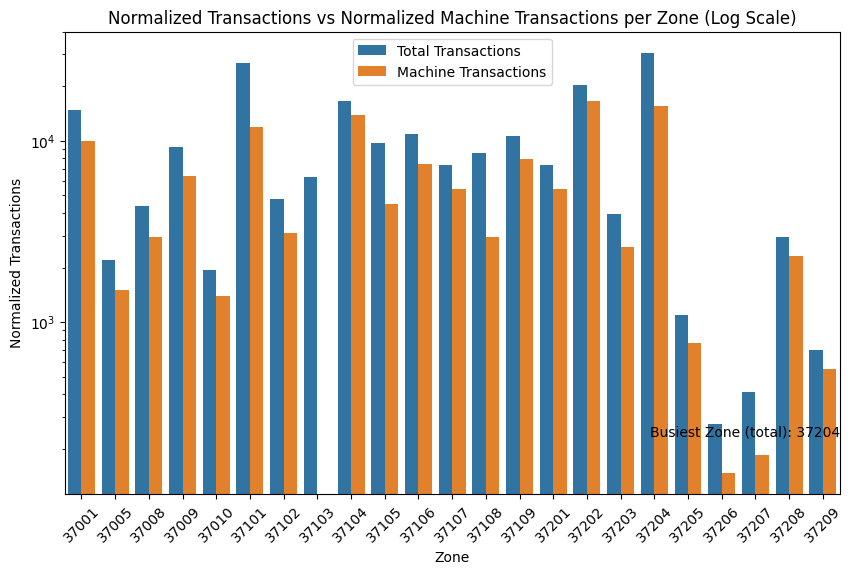

___
## Exercise 3: Statistics (18 points)


#### Exercise 3.1 - t-Test (13 points)
In addition to our visual analysis, we now also want to carry out a statistical study of machine vs. app usage.

To do this, determine the daily rate of machine use per parkzone. Carry out a t-test **for each parkzone**, which statistically tests whether parkers prefer to use the app in the respective zone. Write down the corresponding pair of hypotheses, carry out the test and interpret your test results. Use a significance level of 0.05 for your test decision. Which fundamental assumption of the statistical test could be violated?

#### Exercise 3.2 - Statistical Reasoning (5 points)
Assume that for zone `37106` the rate of app users (and thus the rate of machine users) is `0.5`. 
The city sends you the data for 2024. 

How many days can you expect the app usage rate to be significantly greater than the machine usage rate at a significance level of 5%? Explain why that is the case. Assume that the behavior of the users has not changed compared to 2023.

___
## Exercise 4: Machine Learning (20 points)

Use the k-Nearest Neighbors (k-NN) algorithm to build a machine learning model that predicts the parking method (app or machine) based on location and fee as input features. Use parking data between fee value 2 euros and 7 euros.

#### Excersice 4.1 - Model Building and Hyperparameter Search (10 points)
Preprocess the data appropriately, perform hyperparameter search with cross validation for the optimal k value, visualize your optimal choice of k and finally use your optimal k-value to build the model.

**Hint:** Use 30% of all the data to speed up hyperparameter search and use the whole dataset for model building

#### Exercise 4.2 - Visualizing Model Predictions (10 points)
Create a `100 x 100` grid of longitude/latitude values using the min and max values from your dataset and visualize the predictions of the k-NN model **for three different parking fees** - 3, 5, and 7 euros, using the `plot_map` function. Set the color of the markers on the map to your prediction. Point out at least 2 visual changes in the predicted pattern of parking method across the city for these three different fee values.